<a href="https://colab.research.google.com/github/Olivia-Feldman/DLStockPrectionCNNModel-/blob/Olivia/olivia_stock_predictor_CNN%2BLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Default Imports

In [14]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from sklearn.preprocessing import StandardScaler, MinMaxScaler
!pip install pandas_ta
import pandas_ta as ta

# Set Plot Stylizations

In [7]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = [12, 8]
plt.style.use('dark_background')

# Method for getting ticker data using Yahoo Finance API

This method downloads json data from the Yahoo! finance API and organizes it into a Pandas dataframe. The time frame of the data can start and end wherever the user wants it to. The start and end dates need to be a String in the form of a Unix Timestamp.

*Parameters:*

    ticker: String that specifies the trading ticker of the equity 
    startData: String that specifies the start time of the dataset. Formatted as a Unix Timestamp
    endData: String that specifies the start time of the dataset. Formatted as a Unix Timestamp

*Returns:*

    df: Pandas dataframe with timestamp, open, high, low, close, and volume of a ticker


*Resources:*
*   [Dataframe.shift](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html)



In [8]:
def getStockDataInRange(ticker: str, startDate: str, endDate: str):
    url = "https://query1.finance.yahoo.com/v8/finance/chart/" + ticker + "?period1=" + startDate + "&period2=" + endDate + "&useYfid=true&interval=1d&includePrePost=true&events=div%7Csplit%7Cearn&lang=en-US&region=US&crumb=Yo9B6QaqJUD&corsDomain=finance.yahoo.com"
    x = requests.get(url)
    jsonResponse = x.json()
    timestamps = jsonResponse["chart"]["result"][0]["timestamp"]
    open = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["open"]
    high = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["high"]
    low = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["low"]
    close = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["close"]
    volume = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["volume"]

    datetimes = list(map(toDatetime, timestamps))

    data = {
        'timestamps' : datetimes,
        'open' : open,
        'high' : high,
        'low' : low,
        'close' : close,
        'volume' : volume
    }

    df = pd.DataFrame(data, columns=['timestamps', 'open', 'high', 'low', 'close', 'volume'])
    # Difference if based on 'close' price
    df['diff'] = df['close'].diff()
    df['change'] = df['diff'] / df['close'].shift(periods=1) * 100
    return df

def toDatetime(t):
    return datetime.fromtimestamp(t)

# Creating Dataframe with stock data

In [9]:
ticker = 'QQQ'
endDate = datetime.now().strftime('%s')
startDate = datetime(year=2009, month=1, day=1, hour=0, minute=0).strftime('%s')

df = getStockDataInRange(ticker=ticker, startDate=startDate, endDate=endDate)

# Function for plotting stock prices of data frame

In [10]:
def visualize_prices(df, x_values, y_values):
    ax = df.plot(x=x_values, y=[y_values], kind='line', title=ticker + ' prices in set range')
    vals = ax.get_yticks()
    ax.set_yticklabels(['${:1.2f}'.format(x) for x in vals])
    ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.25)
    ax.set_axisbelow(True)
    ax.grid(linestyle='-', linewidth='0.5', color='gray')

    plt.show()

# Plotting QQQ open prices from January 1, 2009 to the current day using Unix Timestamps

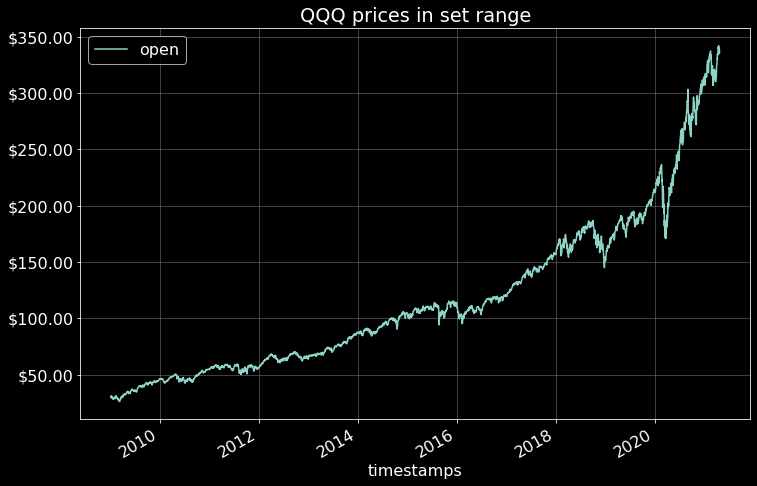

In [11]:
visualize_prices(df, 'timestamps', 'open')

# ax = df.plot(x='timestamps', y=['open'], kind='line', title=ticker + ' prices in set range')
# vals = ax.get_yticks()
# ax.set_yticklabels(['${:1.2f}'.format(x) for x in vals])
# ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.25)
# ax.set_axisbelow(True)
# ax.grid(linestyle='-', linewidth='0.5', color='gray')

# plt.show()

# Showing Dataframe head

In [ ]:
df.head()

,timestamps,open,high,low,close,volume,diff,change
0,2009-01-02 14:30:00,29.750000,31.129999,29.690001,31.030001,107891500,NaN,NaN
1,2009-01-05 14:30:00,30.830000,31.330000,30.590000,31.020000,91751900,-0.010000,-0.032228
2,2009-01-06 14:30:00,31.250000,31.629999,31.110001,31.330000,136791700,0.309999,0.999354
3,2009-01-07 14:30:00,30.730000,30.900000,30.190001,30.440001,133879800,-0.889999,-2.840726
4,2009-01-08 14:30:00,30.379999,30.799999,30.080000,30.760000,131926600,0.320000,1.051247


# Creating Training Data

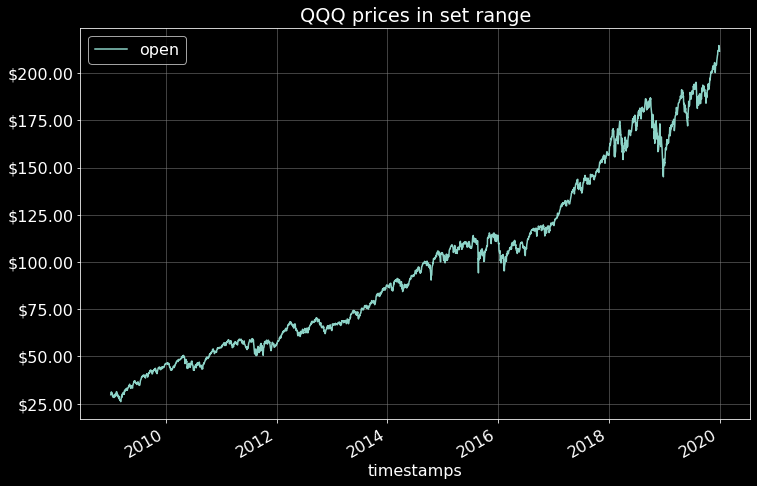

            open        high         low  ...     volume      diff    change
1      30.830000   31.330000   30.590000  ...   91751900 -0.010000 -0.032228
2      31.250000   31.629999   31.110001  ...  136791700  0.309999  0.999354
3      30.730000   30.900000   30.190001  ...  133879800 -0.889999 -2.840726
4      30.379999   30.799999   30.080000  ...  131926600  0.320000  1.051247
5      30.770000   30.790001   29.920000  ...  117137900 -0.690001 -2.243175
...          ...         ...         ...  ...        ...       ...       ...
2763  212.000000  212.089996  211.440002  ...    7089000  0.110001  0.051934
2764  212.259995  213.809998  212.229996  ...   17067500  1.869995  0.882406
2765  214.539993  214.559998  213.039993  ...   18134100 -0.179993 -0.084191
2766  213.500000  213.630005  211.160004  ...   21815500 -1.399994 -0.655397
2767  211.529999  212.759995  211.199997  ...   18170900  0.399994  0.188490

[2767 rows x 7 columns]


In [17]:
training_data = df[df['timestamps']<'2020-01-01'].copy()

visualize_prices(training_data, 'timestamps', 'open')

training_data = training_data.drop(['timestamps'], axis=1)
training_data = training_data.iloc[1:]    # Drops first row in dataframe
training_copy = training_data   # Need this to append last n row to testing data later
print(training_data )
#training_data.head() 

In [29]:
from pandas_ta import ppo,hma,psar,cmo,tema,cmf,trix, kst,macd,roc,ema,dema,cci,rsi,willr,stoch,mfi,bbands
import pandas_ta  as ta

In [42]:
    dftemp = pd.DataFrame
    dftemp = bbands(df['close']).fillna(0)
    print(dftemp)

       BBL_5_2.0   BBM_5_2.0   BBU_5_2.0  BBB_5_2.0
0       0.000000    0.000000    0.000000   0.000000
1       0.000000    0.000000    0.000000   0.000000
2       0.000000    0.000000    0.000000   0.000000
3       0.000000    0.000000    0.000000   0.000000
4      30.248079   30.916000   31.583922   4.320881
...          ...         ...         ...        ...
3093  335.405788  339.922003  344.438219   2.657207
3094  333.721221  339.084003  344.446785   3.163099
3095  335.097894  339.640002  344.182111   2.674661
3096  333.043322  338.358008  343.672693   3.141457
3097  334.006602  337.840009  341.673415   2.269362

[3098 rows x 4 columns]


In [66]:

######################################## Trend Indicators ############################

# MACD: Moving Average Convergance Diverage Momentum
def calculate_macd(df, iteration):
    dftemp = pd.DataFrame
    dftemp = macd(df['close']).fillna(0)
    df['MACD_'+str(iteration)] = dftemp['MACD_12_26_9' ]
# ROC: Price Rate of Change
def calculate_roc(df, iteration):
    dftemp = pd.DataFrame
    dftemp = roc(df['close']).fillna(0)
    df['ROC_'+str(iteration)] = dftemp
# EMA: Exponential Moving Average
def calculate_ema(df, iteration):
    dftemp = pd.DataFrame
    dftemp = ema(df['close']).fillna(0)
    df['EMA_'+str(iteration)] = dftemp

# DEMA: Double Exponential Moving Average
def calculate_dema(df, iteration):
    dftemp = pd.DataFrame
    dftemp = dema(df['close']).fillna(0)
    df['DEMA_'+str(iteration)] = dftemp
   
# CCI: Commodity Channel Index
def calculate_cci(df, iteration):  
    dftemp = pd.DataFrame
    dftemp = cci(df['high'],df['low'],df['close']).fillna(0)
    df['CCI_'+str(iteration)] = dftemp

# RSI: Relative Strength Index     
def calculate_rsi(df, iteration):
    dftemp = pd.DataFrame
    dftemp = rsi(df['close']).fillna(0)
    df['RSI_'+str(iteration)] = dftemp

# WR: Williams %R Indicator
def calculate_WR(df, iteration):
    dftemp = pd.DataFrame
    dftemp = willr(df['high'],df['low'],df['close']).fillna(0)
    df['WR_'+str(iteration)] = dftemp

# SR: Stochastic Oscillator
def calculate_sr(df, iteration):
    dftemp = pd.DataFrame
    dftemp = stoch(df['high'],df['low'],df['close']).fillna(0)
    df['SR_'+str(iteration)] = dftemp["STOCHd_14_3_3"]

# MFI: Money Flow Index
def calculate_mfi(df, iteration):
    dftemp = pd.DataFrame
    dftemp = mfi(df['high'],df['low'],df['close'],df['volume']).fillna(0)
    df['MFI_'+str(iteration)] = dftemp
 # BB: Bollinger Band look at data frame return  
def calculate_bb(df, iteration):
    dftemp = pd.DataFrame
    dftemp = bbands(df['close']).fillna(0)
    df['BB_'+str(iteration)] = dftemp['BBB_5_2.0']
def calculate_cmo(df,iteration):
    dftemp = pd.DataFrame
    dftemp = cmo(df['close'])
    df['CMO_' + str(iteration)] = dftemp.fillna(0)
def calculate_tema(df,iteration):
    dftemp = pd.DataFrame
    dftemp = tema(df['close'])
    df['TEMA_' + str(iteration)] = dftemp.fillna(0)
def calculate_cmf(df,iteration):
    dftemp = pd.DataFrame
    dftemp = cmf(df['high'],df['low'],df['close'],df['volume']).fillna(0)
    df['CMF_' + str(iteration)] = dftemp
def calculate_trix(df,iteration):
    dftemp = pd.DataFrame
    dftemp = trix(df['close']).fillna(0)
    df['TRIX_' + str(iteration)] = dftemp['TRIX_30_9']
def calculate_kst(df,iteration):
    dftemp = pd.DataFrame
    dftemp = kst(df['close']).fillna(0)
    df['KST_' + str(iteration)] = dftemp['KST_10_15_20_30_10_10_10_15']

In [67]:
indicator_range = 20
x = 6

for x in range(6, indicator_range+1):
    calculate_macd(df, x)
for x in range(6, indicator_range+1):
    calculate_rsi(df, x)
for x in range(6, indicator_range+1):
    calculate_sr(df, x)
for x in range(6, indicator_range+1):
    calculate_WR(df, x)
for x in range(6, indicator_range+1):
    calculate_ema(df, x)
for x in range(6, indicator_range+1):
    calculate_mfi(df, x)
for x in range(6, indicator_range+1):
    calculate_bb(df, x)
for x in range(6, indicator_range+1):
    calculate_dema(df, x)
for x in range(6, indicator_range+1):
    calculate_cci(df, x)
for x in range(6, indicator_range+1):
    calculate_roc(df, x)
for x in range(6, indicator_range+1):
    calculate_cmo(df, x)
for x in range(6, indicator_range+1):
    calculate_tema(df, x)
for x in range(6, indicator_range+1):
    calculate_cmf(df, x)
for x in range(6, indicator_range+1):
    calculate_trix(df, x)
for x in range(6, indicator_range+1):
    calculate_kst(df, x)

In [68]:
from sklearn.model_selection import train_test_split
list_features = list(df.loc[:, 'open': 'KST_'+str(indicator_range)].columns) # Gets the names of all the columns from MACD to RSI
print('Total number of features', len(list_features))
print("Columns:", list_features)

x_train, x_test, y_train, y_test = train_test_split(df.loc[:, 'MACD_6': 'KST_'+str(indicator_range)].values, df['open'].values, train_size=0.8, test_size=0.2, random_state=1, shuffle=True)

Total number of features 391
Columns: ['open', 'high', 'low', 'close', 'volume', 'diff', 'change', 'MACD_1', 'MACD_2', 'MACD_3', 'MACD_4', 'MACD_5', 'MACD_6', 'MACD_7', 'MACD_8', 'MACD_9', 'MACD_10', 'MACD_11', 'MACD_12', 'MACD_13', 'MACD_14', 'MACD_15', 'MACD_16', 'MACD_17', 'MACD_18', 'MACD_19', 'MACD_20', 'MACD_21', 'MACD_22', 'MACD_23', 'MACD_24', 'MACD_25', 'MACD_26', 'RSI_1', 'RSI_2', 'RSI_3', 'RSI_4', 'RSI_5', 'RSI_6', 'RSI_7', 'RSI_8', 'RSI_9', 'RSI_10', 'RSI_11', 'RSI_12', 'RSI_13', 'RSI_14', 'RSI_15', 'RSI_16', 'RSI_17', 'RSI_18', 'RSI_19', 'RSI_20', 'RSI_21', 'RSI_22', 'RSI_23', 'RSI_24', 'RSI_25', 'RSI_26', 'SR_1', 'SR_2', 'SR_3', 'SR_4', 'SR_5', 'SR_6', 'SR_7', 'SR_8', 'SR_9', 'SR_10', 'SR_11', 'SR_12', 'SR_13', 'SR_14', 'SR_15', 'SR_16', 'SR_17', 'SR_18', 'SR_19', 'SR_20', 'SR_21', 'SR_22', 'SR_23', 'SR_24', 'SR_25', 'SR_26', 'WR_1', 'WR_2', 'WR_3', 'WR_4', 'WR_5', 'WR_6', 'WR_7', 'WR_8', 'WR_9', 'WR_10', 'WR_11', 'WR_12', 'WR_13', 'WR_14', 'WR_15', 'WR_16', 'WR_17', 'WR_

# Creating Testing Data

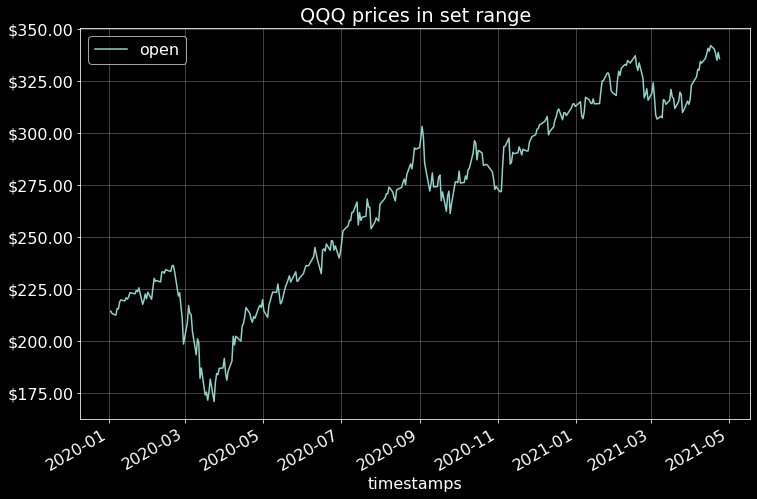

,open,high,low,close,volume,diff,change,MACD_1,MACD_2,MACD_3,MACD_4,MACD_5,MACD_6,MACD_7,MACD_8,MACD_9,MACD_10,MACD_11,MACD_12,MACD_13,MACD_14,MACD_15,MACD_16,MACD_17,MACD_18,MACD_19,MACD_20,MACD_21,MACD_22,MACD_23,MACD_24,MACD_25,MACD_26,RSI_1,RSI_2,RSI_3,RSI_4,RSI_5,RSI_6,RSI_7,...,TRIX_13,TRIX_14,TRIX_15,TRIX_16,TRIX_17,TRIX_18,TRIX_19,TRIX_20,TRIX_21,TRIX_22,TRIX_23,TRIX_24,TRIX_25,TRIX_26,KST_1,KST_2,KST_3,KST_4,KST_5,KST_6,KST_7,KST_8,KST_9,KST_10,KST_11,KST_12,KST_13,KST_14,KST_15,KST_16,KST_17,KST_18,KST_19,KST_20,KST_21,KST_22,KST_23,KST_24,KST_25,KST_26
2769,213.300003,215.470001,213.279999,214.179993,27518900,-1.980011,-0.915993,3.169081,3.169081,3.169081,3.169081,3.169081,3.169081,3.169081,3.169081,3.169081,3.169081,3.169081,3.169081,3.169081,3.169081,3.169081,3.169081,3.169081,3.169081,3.169081,3.169081,3.169081,3.169081,3.169081,3.169081,3.169081,3.169081,68.416915,68.416915,68.416915,68.416915,68.416915,68.416915,68.416915,...,0.155989,0.155989,0.155989,0.155989,0.155989,0.155989,0.155989,0.155989,0.155989,0.155989,0.155989,0.155989,0.155989,0.155989,4772.974812,4772.974812,4772.974812,4772.974812,4772.974812,4772.974812,4772.974812,4772.974812,4772.974812,4772.974812,4772.974812,4772.974812,4772.974812,4772.974812,4772.974812,4772.974812,4772.974812,4772.974812,4772.974812,4772.974812,4772.974812,4772.974812,4772.974812,4772.974812,4772.974812,4772.974812
2770,212.500000,215.589996,212.240005,215.559998,21655300,1.380005,0.644320,3.209875,3.209875,3.209875,3.209875,3.209875,3.209875,3.209875,3.209875,3.209875,3.209875,3.209875,3.209875,3.209875,3.209875,3.209875,3.209875,3.209875,3.209875,3.209875,3.209875,3.209875,3.209875,3.209875,3.209875,3.209875,3.209875,71.113746,71.113746,71.113746,71.113746,71.113746,71.113746,71.113746,...,0.158401,0.158401,0.158401,0.158401,0.158401,0.158401,0.158401,0.158401,0.158401,0.158401,0.158401,0.158401,0.158401,0.158401,4903.585502,4903.585502,4903.585502,4903.585502,4903.585502,4903.585502,4903.585502,4903.585502,4903.585502,4903.585502,4903.585502,4903.585502,4903.585502,4903.585502,4903.585502,4903.585502,4903.585502,4903.585502,4903.585502,4903.585502,4903.585502,4903.585502,4903.585502,4903.585502,4903.585502,4903.585502
2771,215.639999,216.139999,214.850006,215.529999,22139300,-0.029999,-0.013917,3.202864,3.202864,3.202864,3.202864,3.202864,3.202864,3.202864,3.202864,3.202864,3.202864,3.202864,3.202864,3.202864,3.202864,3.202864,3.202864,3.202864,3.202864,3.202864,3.202864,3.202864,3.202864,3.202864,3.202864,3.202864,3.202864,70.971876,70.971876,70.971876,70.971876,70.971876,70.971876,70.971876,...,0.160747,0.160747,0.160747,0.160747,0.160747,0.160747,0.160747,0.160747,0.160747,0.160747,0.160747,0.160747,0.160747,0.160747,4956.208191,4956.208191,4956.208191,4956.208191,4956.208191,4956.208191,4956.208191,4956.208191,4956.208191,4956.208191,4956.208191,4956.208191,4956.208191,4956.208191,4956.208191,4956.208191,4956.208191,4956.208191,4956.208191,4956.208191,4956.208191,4956.208191,4956.208191,4956.208191,4956.208191,4956.208191
2772,215.500000,218.139999,215.160004,217.149994,26397300,1.619995,0.751633,3.290101,3.290101,3.290101,3.290101,3.290101,3.290101,3.290101,3.290101,3.290101,3.290101,3.290101,3.290101,3.290101,3.290101,3.290101,3.290101,3.290101,3.290101,3.290101,3.290101,3.290101,3.290101,3.290101,3.290101,3.290101,3.290101,73.989612,73.989612,73.989612,73.989612,73.989612,73.989612,73.989612,...,0.163181,0.163181,0.163181,0.163181,0.163181,0.163181,0.163181,0.163181,0.163181,0.163181,0.163181,0.163181,0.163181,0.163181,5038.906550,5038.906550,5038.906550,5038.906550,5038.906550,5038.906550,5038.906550,5038.906550,5038.906550,5038.906550,5038.906550,5038.906550,5038.906550,5038.906550,5038.906550,5038.906550,5038.906550,5038.906550,5038.906550,5038.906550,5038.906550,5038.906550,5038.906550,5038.906550,5038.906550,5038.906550
2773,218.940002,219.410004,217.710007,218.990005,23547000,1.840012,0.847346,3.467736,3.467736,3.467736,3.467736,3.467736,3.467736,3.467736

In [51]:
testing_data = df[df['timestamps']>='2020-01-01'].copy()
visualize_prices(testing_data, 'timestamps', 'open')

testing_data = testing_data.drop(['timestamps'], axis=1)
testing_data = testing_data.iloc[1:]    # Drops first row in dataframe
testing_data.head() 

# Using z-score standardization

In [ ]:
# from scipy import stats

# training_data = stats.zscore(training_data, axis=0, ddof=0, nan_policy='omit')

# n_bins = 50

# fig, axs = plt.subplots(2, 4, sharey=True, tight_layout=True)
# axs[0][0].hist(training_data[:, 0], bins=n_bins)
# axs[0][1].hist(training_data[:, 1], bins=n_bins)
# axs[0][2].hist(training_data[:, 2], bins=n_bins)
# axs[0][3].hist(training_data[:, 3], bins=n_bins)
# axs[1][0].hist(training_data[:, 4], bins=n_bins)
# axs[1][1].hist(training_data[:, 5], bins=n_bins)
# axs[1][2].hist(training_data[:, 6], bins=n_bins)

# Normalize data between 0 and 1

In [ ]:
scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data)
training_data.shape

(2767, 7)

# Create data with time_step = 10

In [ ]:
time_step = 10

x_train = []
y_train = []

for i in range(time_step, training_data.shape[0]):
    x_train.append(training_data[i-time_step:i])
    y_train.append(training_data[i, 0])

print(len(y_train))

2757


In [ ]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape, y_train.shape

((2757, 10, 7), (2757,))

# Import needed Keras components

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPool1D, Activation

# Build CNN-LSTM model

In [ ]:
filters = 32

model = Sequential([
    Conv1D(filters=filters, 
           kernel_size=1, 
           padding='same', 
           activation='tanh', 
           input_shape=(x_train.shape[1], x_train.shape[2])),
    MaxPool1D(pool_size=1, padding='same'),
    Activation('relu'),
    LSTM(units=64, 
         activation='relu', 
         #return_sequences=True, 
         input_shape=(x_train.shape[1], filters)),
    #Dropout(0.2),
    # LSTM(
    #     units=80, 
    #     activation='relu'),
    Dense(units=1) # Should I use a kernel initializer?
])

# Show summary of model

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 10, 32)            256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 32)            0         
_________________________________________________________________
activation (Activation)      (None, 10, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 25,153
Trainable params: 25,153
Non-trainable params: 0
_________________________________________________________________


# Compiling model

In [ ]:
from tensorflow.keras import optimizers

learning_rate = 0.001

optimizer = optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(optimizer=optimizer, loss='mean_absolute_error')

# Fitting model

In [ ]:
model.fit(x_train, y_train, epochs=100, batch_size=64)

Epoch 1/100
44/44 [==============================] - 2s 8ms/step - loss: 0.1458
Epoch 2/100
44/44 [==============================] - 0s 8ms/step - loss: 0.0091
Epoch 3/100
44/44 [==============================] - 0s 8ms/step - loss: 0.0061
Epoch 4/100
44/44 [==============================] - 0s 8ms/step - loss: 0.0064
Epoch 5/100
44/44 [==============================] - 0s 9ms/step - loss: 0.0077
Epoch 6/100
44/44 [==============================] - 0s 9ms/step - loss: 0.0042
Epoch 7/100
44/44 [==============================] - 0s 8ms/step - loss: 0.0076
Epoch 8/100
44/44 [==============================] - 0s 8ms/step - loss: 0.0039
Epoch 9/100
44/44 [==============================] - 0s 9ms/step - loss: 0.0043
Epoch 10/100
44/44 [==============================] - 0s 8ms/step - loss: 0.0038
Epoch 11/100
44/44 [==============================] - 0s 8ms/step - loss: 0.0053
Epoch 12/100
44/44 [==============================] - 0s 8ms/step - loss: 0.0048
Epoch 13/100
44/44 [=================

# Adding 

In [ ]:
past_n_data_points = training_copy.tail(time_step)
past_df = past_n_data_points.append(testing_data, ignore_index=True)
past_df.head()

,open,high,low,close,volume,diff,change
0,209.539993,209.710007,209.039993,209.389999,15996100,0.119995,0.057340
1,209.570007,210.130005,209.330002,209.550003,15443300,0.160004,0.076414
2,209.639999,210.929993,209.619995,210.860001,17865900,1.309998,0.625148
3,211.860001,212.520004,211.270004,211.710007,27672600,0.850006,0.403114
4,212.000000,212.149994,211.630005,211.809998,23774700,0.099991,0.047230


In [ ]:
inputs = scaler.transform(past_df)
inputs.shape

(338, 7)

In [ ]:
x_test = []
y_test = []
for i in range(time_step, inputs.shape[0]):
    x_test.append(inputs[i-time_step:i])
    y_test.append(inputs[i, 0])

In [ ]:
x_test, y_test = np.array(x_test), np.array(y_test)
x_test.shape, y_test.shape

((328, 10, 7), (328,))

In [ ]:
y_pred = model.predict(x_test)
y_pred.shape

(328, 1)

In [ ]:
y_pred = y_pred/scaler.scale_[0]
y_test = y_test/scaler.scale_[0]
y_pred.shape, y_test.shape

((328, 1), (328,))

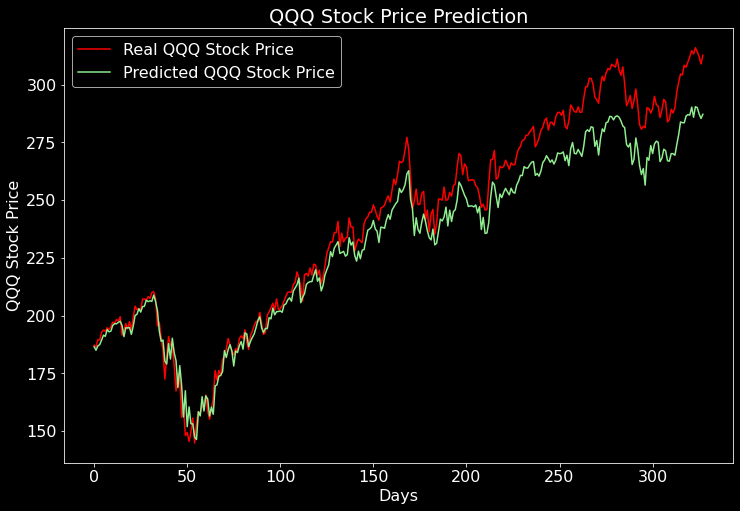

In [ ]:
fig = plt.figure()
plt.plot(y_test, color='red', label='Real ' + ticker + ' Stock Price')
plt.plot(y_pred, color='lightgreen', label='Predicted ' + ticker + ' Stock Price')
plt.title(ticker + " Stock Price Prediction")
plt.xlabel('Days')
plt.ylabel(ticker + ' Stock Price')
plt.legend()
plt.show()

In [ ]:
accuracy = 0

for i in range(1, y_pred.shape[0]):

    # Determining if the actual price increased
    actual_did_increase = y_test[i] > y_test[i-1]
    # Determining if the predicted price increased
    prediction_did_increase = y_pred[i] > y_pred[i-1]
    # If both the actual and predicted prices move in the same direction, 
    # then add 1 to the accuracy
    if (actual_did_increase == prediction_did_increase):
        accuracy = accuracy + 1


# Subtract 1 from y_pred.shape because we are staring at 1 instead of 0
print("Model accuracy: {:.3f}%".format(accuracy / (y_pred.shape[0] - 1) * 100)) 

Model accuracy: 73.089%


# Implementation of trading

In [ ]:
model_variation = []
price_variation = []
buy_points = []
sell_points = []

maximum_trade_size = 3000.00
cash_on_hand = 10000.00
initial_value = cash_on_hand
number_of_shares = 0.00


for i in range(1, y_pred.shape[0]):
    # Current prediction price
    current_pred = y_pred[i][0]
    # Previous prediction price
    previous_pred = y_pred[i-1][0]
    # Current actual price
    current_actual= y_test[i]
    # Previous actual price
    previous_actual = y_test[i-1]

    change = ((current_pred - previous_pred) / previous_pred) * 100

    if (change >= 3):
        #print("Buy" + str(change) + "%")
        # The model is expecting the share price to increase
        # Use previous actual price to determine how many shares to buy
        maximum_allow_trade_size = min(maximum_trade_size, cash_on_hand)
        shares_to_buy = maximum_trade_size / previous_actual
        number_of_shares = number_of_shares + shares_to_buy
        cash_on_hand = cash_on_hand - (shares_to_buy * previous_actual)
        buy_points.append(i-1)
    elif (change <= -3):
        #print("Sell: " + str(change) + "%")
        # The model is expecting the share price to decrease
        # Use previous price to determine how many shares to sell
        shares_to_sell = min(round(maximum_trade_size / previous_actual, 4), number_of_shares)
        number_of_shares = number_of_shares - shares_to_sell
        cash_on_hand = cash_on_hand + (shares_to_sell * previous_actual)
        sell_points.append(i-1)

    starting_price = y_test[1]

    price_variation.append((current_actual - starting_price) / starting_price * 100)
    model_variation.append((cash_on_hand + (number_of_shares * current_actual) - initial_value) / initial_value * 100)

end_price = y_test[-1]
share_value = end_price * number_of_shares

print("Cash left on hand: ${:.3f}".format(cash_on_hand))
print("Number of shares: {:.3f}".format(number_of_shares))
print("Value of shares: {:.3f}".format(share_value))
print("Total value: ${:.3f}".format(cash_on_hand + share_value))

print("Number of trades: {:.3f}".format(len(buy_points) + len(sell_points)))

Cash left on hand: $760.880
Number of shares: 57.558
Value of shares: 18004.145
Total value: $18765.026
Number of trades: 38.000


Text(0.5, 1.0, 'Model vs. Stock % Change Comparison')

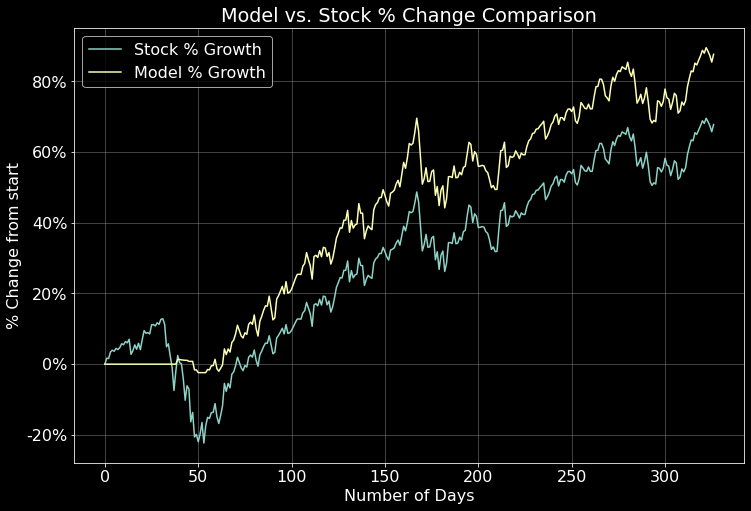

In [ ]:
import matplotlib.ticker as mtick

fig, (ax) = plt.subplots(1, 1, sharex=True)

fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)

ax.plot(price_variation, label='Stock % Growth')
ax.plot(model_variation, label='Model % Growth')

ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.25)
ax.set_axisbelow(True)
ax.grid(linestyle='-', linewidth='0.5', color='gray')

ax.legend(loc='upper left')

ax.set_ylabel('% Change from start')
ax.set_xlabel('Number of Days')
ax.set_title('Model vs. Stock % Change Comparison')

In [ ]:
import matplotlib.ticker as mtick

def marker_visualization(markers):
    fig, (ax) = plt.subplots(1, 1, sharex=True)

    fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
    yticks = mtick.FormatStrFormatter(fmt)
    ax.yaxis.set_major_formatter(yticks)

    ax.plot(price_variation, label='Stock % Growth', markevery=markers, marker='o', markerfacecolor='white')
    ax.plot(model_variation, label='Model % Growth')

    ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.25)
    ax.set_axisbelow(True)
    ax.grid(linestyle='-', linewidth='0.5', color='gray')

    ax.legend(loc='upper left')

    ax.set_ylabel('% Change from start')
    ax.set_xlabel('Number of Days')
    ax.set_title('Model vs. Stock % Change Comparison')

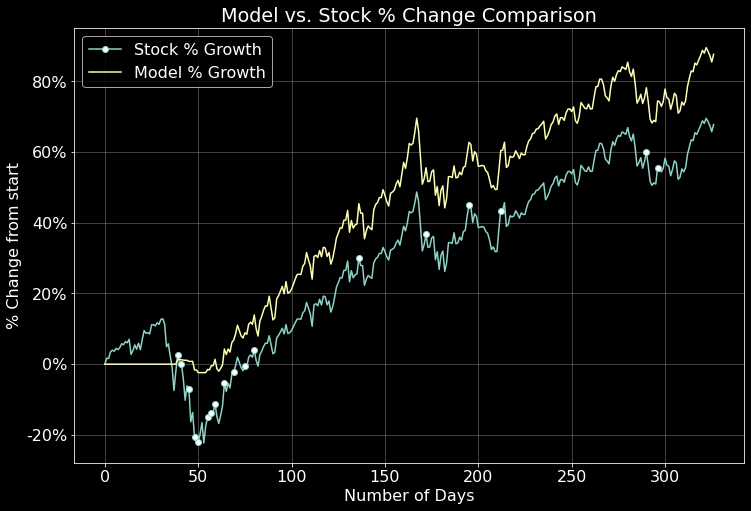

In [ ]:
marker_visualization(markers=buy_points)

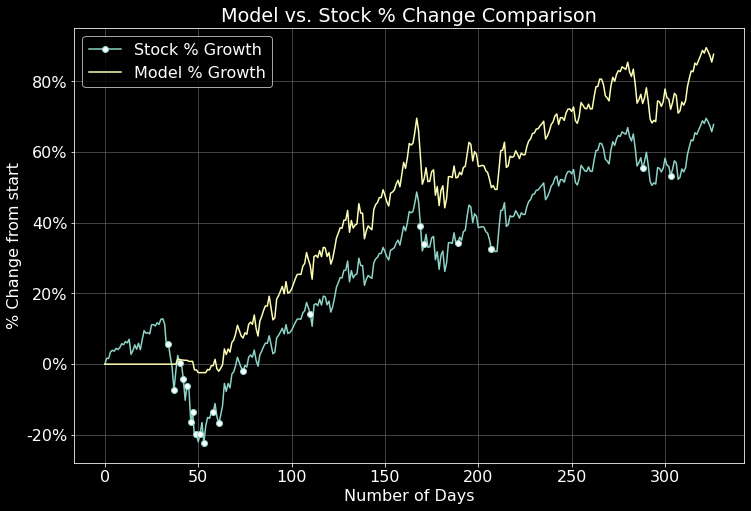

In [ ]:
marker_visualization(markers=sell_points)